# Learning Jammers: Multi-User
In this notebook, we will evaluate Multi-User performance of our learning algorithms

In [2]:
import os
# import drjit
gpu_num = 1 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [3]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 1.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters

### Integrated vs Variable Constraint

In [4]:
sim.MAX_MC_ITER = 100
sim.BATCH_SIZE = 128
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
num_ues = np.arange(1, 5, dtype=np.int32)
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_constraint.pickle"
    jammer_parameters["training_constraint"] = NonNegMaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = False
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    simulate_model(model, f"{num_ue} UE(s), variable constraint")
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_relufix.pickle"
    jammer_parameters["training_constraint"] = MaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = True
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    simulate_model(model, f"{num_ue} UE(s), integrated")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2908e-01 | 1.0000e+00 |     9705108 |    29491200 |        12800 |       12800 |        22.7 |reached max iter       
   -3.667 | 3.2378e-01 | 1.0000e+00 |     9548667 |    29491200 |        12800 |       12800 |        16.2 |reached max iter       
   -2.333 | 3.2073e-01 | 1.0000e+00 |     9458582 |    29491200 |        12800 |       12800 |        16.2 |reached max iter       
     -1.0 | 3.1803e-01 | 1.0000e+00 |     9379172 |    29491200 |        12800 |       12800 |        16.3 |reached max iter       
    0.333 | 3.1530e-01 | 1.0000e+00 |     9298512 |    29491200 |        12800 |       12800 |        16.3 |reached max iter       
    1.667 | 3.1330e-01 | 1.0000e+00 |     9239619 |    29491200 |        12800 |     

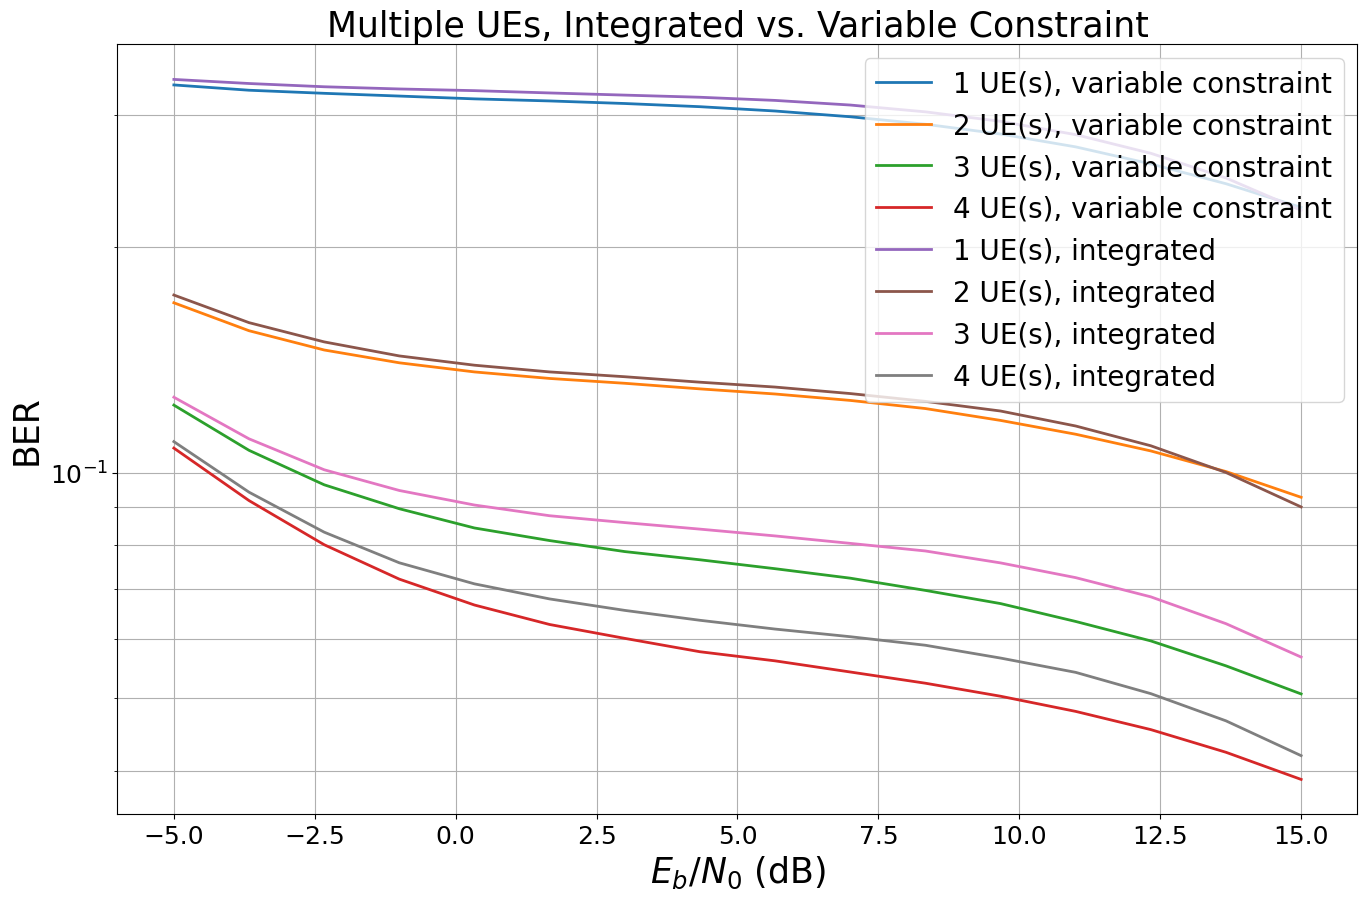

In [5]:
ber_plots.title = "Multiple UEs, Integrated vs. Variable Constraint"
ber_plots()
with open("bers/report/learning/integrated_vs_variable_constraint.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

In [26]:
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_relufix_constraint.pickle"
    jammer_parameters["training_constraint"] = MaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = False
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    # c.b.n: can be negative
    simulate_model(model, f"{num_ue} UE(s), variable constraint (c.b.n.)")
# reset jammer_parameters
jammer_parameters["training_constraint"] = MaxMeanSquareNorm(1.0)
jammer_parameters["constraint_integrated"] = True

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2949e-01 | 1.0000e+00 |      455493 |     1382400 |          600 |         600 |        13.4 |reached max iter       
   -3.571 | 3.2527e-01 | 1.0000e+00 |      449648 |     1382400 |          600 |         600 |         7.3 |reached max iter       
   -2.143 | 3.2059e-01 | 1.0000e+00 |      443185 |     1382400 |          600 |         600 |         7.3 |reached max iter       
   -0.714 | 3.1790e-01 | 1.0000e+00 |      439466 |     1382400 |          600 |         600 |         7.5 |reached max iter       
    0.714 | 3.1662e-01 | 1.0000e+00 |      437695 |     1382400 |          600 |         600 |         7.5 |reached max iter       
    2.143 | 3.1316e-01 | 1.0000e+00 |      432914 |     1382400 |          600 |     

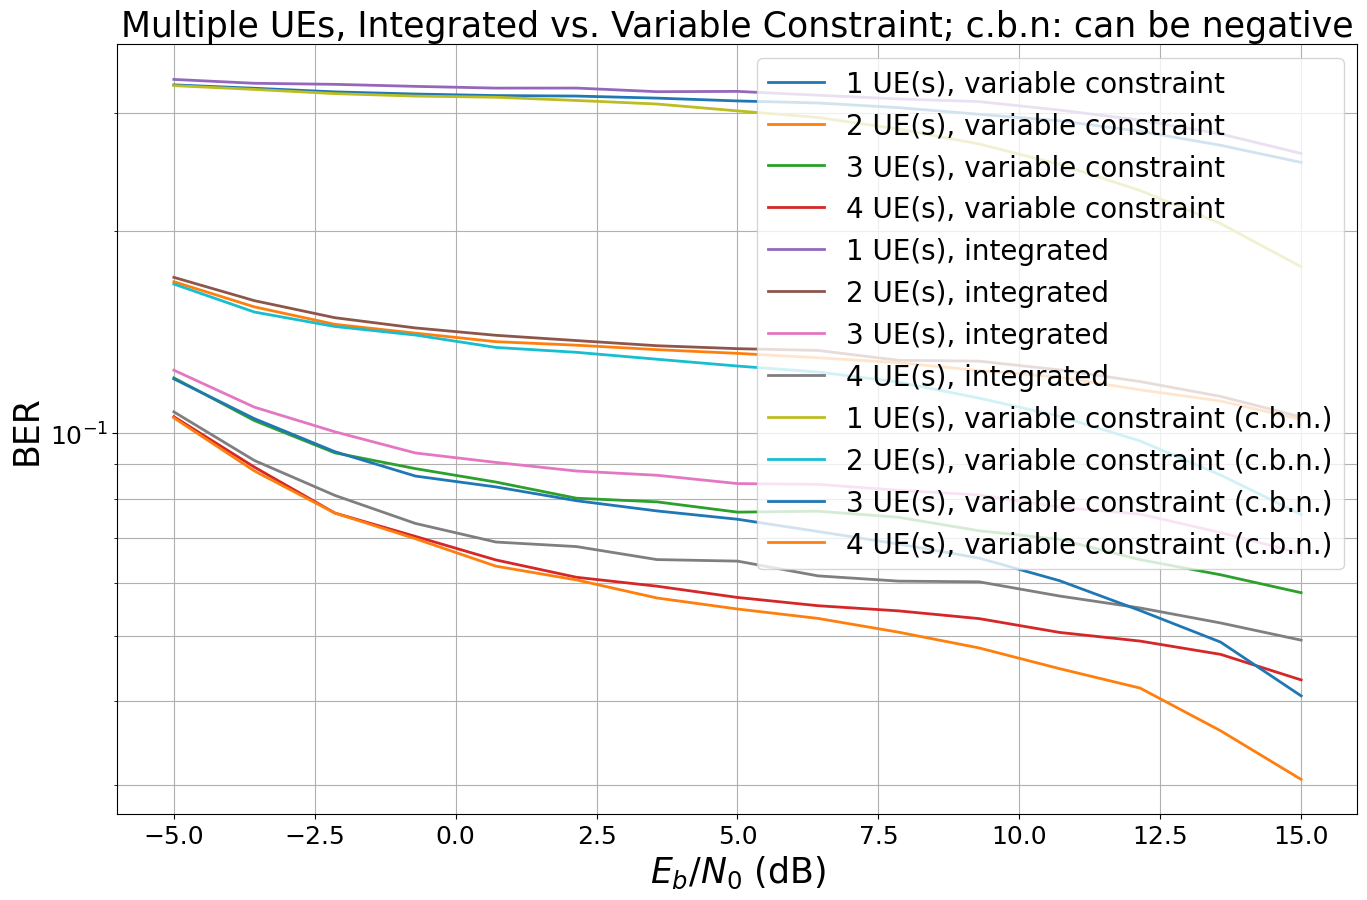

In [27]:
ber_plots.title = "Multiple UEs, Integrated vs. Variable Constraint; c.b.n: can be negative"
ber_plots()

### Comparison with Symbol Weight Learning

Comparison of best result (integrated constraint) against same setup but with symboltime-only weights.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3481e-01 | 1.0000e+00 |     9874035 |    29491200 |        12800 |       12800 |        22.6 |reached max iter       
   -3.667 | 3.3046e-01 | 1.0000e+00 |     9745585 |    29491200 |        12800 |       12800 |        16.2 |reached max iter       
   -2.333 | 3.2750e-01 | 1.0000e+00 |     9658338 |    29491200 |        12800 |       12800 |        16.2 |reached max iter       
     -1.0 | 3.2503e-01 | 1.0000e+00 |     9585644 |    29491200 |        12800 |       12800 |        16.0 |reached max iter       
    0.333 | 3.2314e-01 | 1.0000e+00 |     9529749 |    29491200 |        12800 |       12800 |        16.7 |reached max iter       
    1.667 | 3.2084e-01 | 1.0000e+00 |     9462078 |    29491200 |        12800 |     

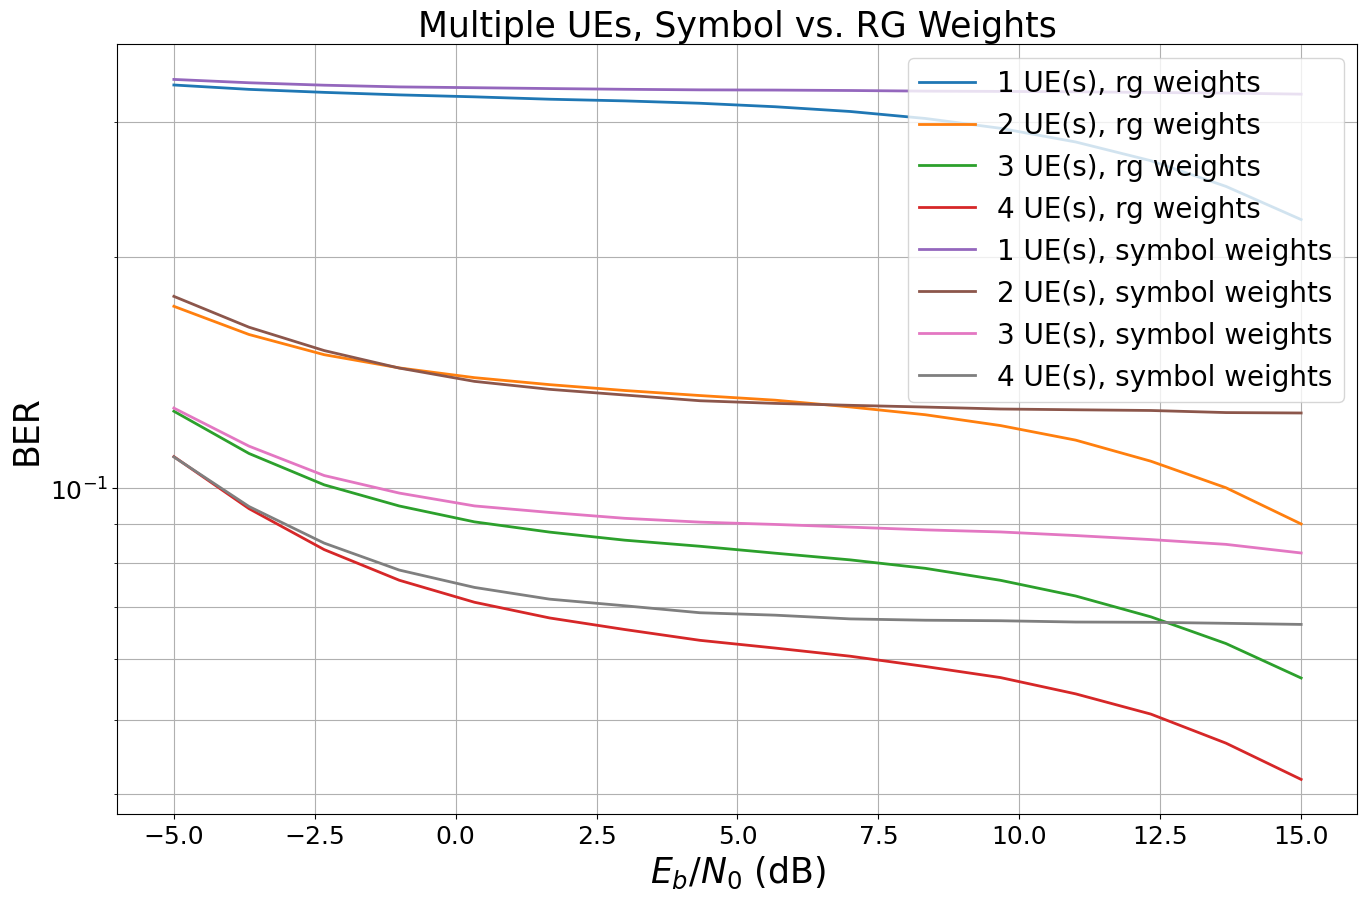

In [6]:
ber_plots.reset()
sim.MAX_MC_ITER = 100
sim.BATCH_SIZE = 128
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
num_ues = np.arange(1, 5, dtype=np.int32)
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_relufix.pickle"
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    simulate_model(model, f"{num_ue} UE(s), rg weights")
jammer_parameters["trainable_mask"] = tf.ones([14, 1])
for num_ue in num_ues:
    filename = f"weights/ue_{num_ue}_relufix_symbol_weights.pickle"
    model = Model(**{**model_parameters, "num_ut": num_ue})
    load_weights(model, filename)
    simulate_model(model, f"{num_ue} UE(s), symbol weights")
ber_plots.title = "Multiple UEs, Symbol vs. RG Weights"
ber_plots()
with open("bers/report/learning/rg_vs_symbol_weight.pickle", "wb") as f:
    pickle.dump(ber_plots, f)


### Number of Users vs. Jammer Power

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 1.1265e-01 | 1.0000e+00 |    13289069 |   117964800 |        19200 |       19200 |        35.9 |reached max iter       
   -3.667 | 9.6761e-02 | 1.0000e+00 |    11414439 |   117964800 |        19200 |       19200 |        30.0 |reached max iter       
   -2.333 | 8.5162e-02 | 1.0000e+00 |    10046145 |   117964800 |        19200 |       19200 |        29.7 |reached max iter       
     -1.0 | 7.7476e-02 | 1.0000e+00 |     9139469 |   117964800 |        19200 |       19200 |        29.6 |reached max iter       
    0.333 | 7.2356e-02 | 1.0000e+00 |     8535480 |   117964800 |        19200 |       19200 |        29.6 |reached max iter       
    1.667 | 6.8724e-02 | 1.0000e+00 |     8107064 |   117964800 |        19200 |     

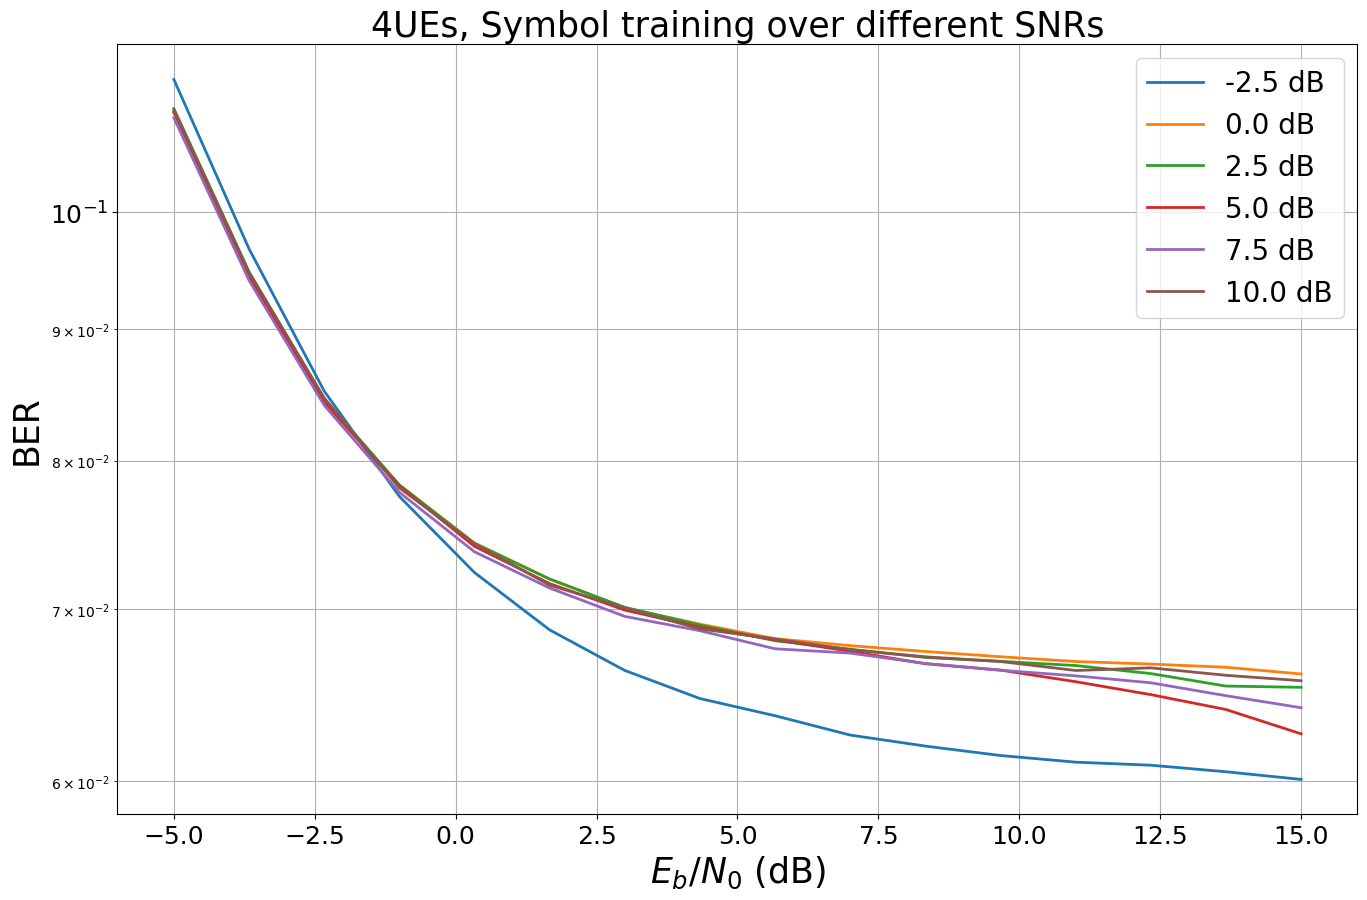

In [7]:
ber_plots.reset()
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 128
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 1])
snrs = np.arange(-2.5, 10.5, 2.5, dtype=np.float32)
for snr in snrs:
    filename = f"weights/ue_4_{snr}dB.pickle"
    model = Model(**{**model_parameters, "num_ut": 4})
    load_weights(model, filename)
    simulate_model(model, f"{snr} dB")
ber_plots.title = "4UEs, Symbol training over different SNRs"
ber_plots()
with open("bers/report/learning/snr_symbol_weight.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

In [5]:
num_ut = range(1, 9)
jammer_power = np.arange(-2.5, 15.1, 2.5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        my_model_parameters = {**model_parameters, "num_ut": n, "jammer_power": db_to_linear(p),
                               "num_ofdm_symbols": 18, "fft_size": 64,
                               "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([18, 1], dtype=tf.bool)}}
        filename = f"weights/grid/ue_{n}_power_{p}dB.pickle"
        model = Model(**my_model_parameters)
        load_weights(model, filename)
        ber = sionna.utils.BitErrorRate()
        for s in range(150):
            # BATCH_SIZE, ebno_db
            b, llr = model(8, 5.0)
            b_hat = sionna.utils.hard_decisions(llr)
            ber.update_state(b, b_hat)
        print(f"{n} UEs, {p} dB: {ber.result().numpy()}")
        bers[i, j] = ber.result().numpy()


1 UEs, -2.5 dB: 0.24985827505588531
1 UEs, 0.0 dB: 0.3429807722568512
1 UEs, 2.5 dB: 0.4055774211883545
1 UEs, 5.0 dB: 0.4435576796531677
1 UEs, 7.5 dB: 0.4681815803050995
1 UEs, 10.0 dB: 0.4811698794364929
1 UEs, 12.5 dB: 0.48852264881134033
1 UEs, 15.0 dB: 0.4898187220096588
2 UEs, -2.5 dB: 0.10608615726232529
2 UEs, 0.0 dB: 0.1445947289466858
2 UEs, 2.5 dB: 0.18897704780101776
2 UEs, 5.0 dB: 0.21670220792293549
2 UEs, 7.5 dB: 0.267534464597702
2 UEs, 10.0 dB: 0.31401094794273376
2 UEs, 12.5 dB: 0.35419678688049316
2 UEs, 15.0 dB: 0.3881022036075592
3 UEs, -2.5 dB: 0.053429409861564636
3 UEs, 0.0 dB: 0.08415798842906952
3 UEs, 2.5 dB: 0.12177635729312897
3 UEs, 5.0 dB: 0.15662483870983124
3 UEs, 7.5 dB: 0.21251164376735687
3 UEs, 10.0 dB: 0.26505425572395325
3 UEs, 12.5 dB: 0.3127077519893646
3 UEs, 15.0 dB: 0.3534071147441864
4 UEs, -2.5 dB: 0.034748535603284836
4 UEs, 0.0 dB: 0.06584016978740692
4 UEs, 2.5 dB: 0.09257210046052933
4 UEs, 5.0 dB: 0.13107812404632568
4 UEs, 7.5 dB: 0.

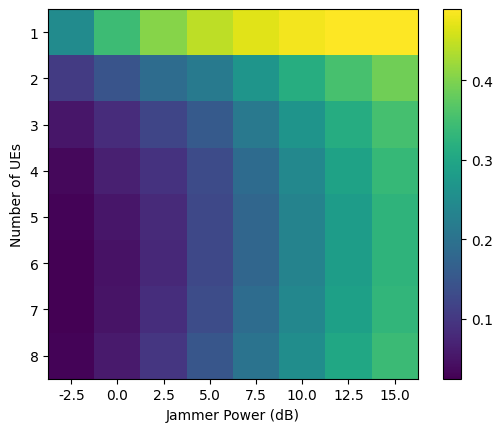

In [20]:
fig, ax = plt.subplots()
im = ax.imshow(bers)
ax.set_xticks(np.arange(len(jammer_power)))
ax.set_xticklabels(jammer_power)
plt.xlabel("Jammer Power (dB)")
ax.set_yticks(np.arange(len(num_ut)))
ax.set_yticklabels(num_ut)
plt.ylabel("Number of UEs")
fig.colorbar(im, fraction=0.05)
plt.show()

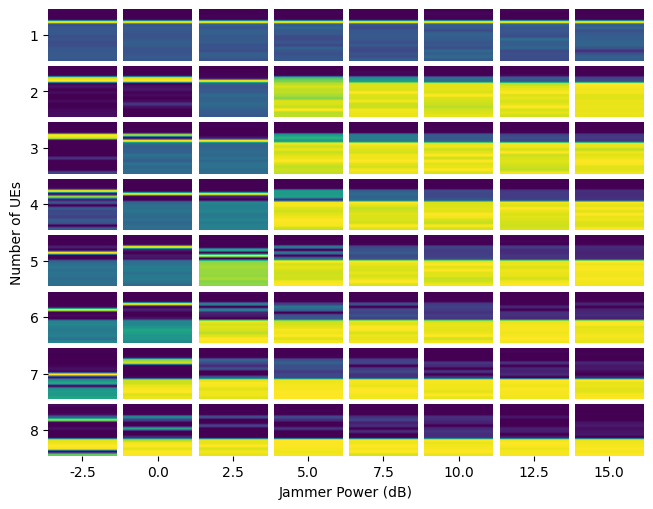

In [93]:
num_ut = range(1, 9)
jammer_power = np.arange(-2.5, 15.1, 2.5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        filename = f"weights/grid/ue_{n}_power_{p}dB.pickle"
        with open(filename, 'rb') as f:
            weights = pickle.load(f)[1]
        weights = NonNegMaxMeanSquareNorm()(weights)
        plt.subplot(len(num_ut), len(jammer_power), i * len(jammer_power) + j + 1)
        plt.axis('off')
        plt.imshow(weights, aspect='auto')

# parameters: space between plots
wspace = 0.1
hspace = 0.1
m = len(num_ut)
n = len(jammer_power)
plt.subplots_adjust(bottom=0.07, top=1.0, left=0.07, right=1.0, wspace=wspace, hspace=hspace)
# labels on the x and y plots-axis
ax = plt.gcf().add_axes([0.07, 0.07, 0.93, 0.93], frameon=False)
plot_width = 1.0 / (n + (n - 1) * wspace)
gap_width = wspace * plot_width
ax.set_xticks(np.arange(plot_width / 2, 1.0, gap_width + plot_width), labels=jammer_power)
ax.set_xlabel("Jammer Power (dB)")
ax.invert_yaxis()
plot_height = 1.0 / (m + (m - 1) * hspace)
gap_height = hspace * plot_height
ax.set_yticks(plot_height / 2 + np.arange(m) * (gap_height + plot_height), labels=num_ut)
ax.set_ylabel("Number of UEs")

plt.show()